# LSTMs

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import pandas as pd
import numpy as np
import csv
import os
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from matplotlib.finance import *
import tensorflow as tf
import keras.backend as K

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima
import scipy.stats as scs

In [4]:
x = np.linspace(0, 2., num=1000)
n_periods = 20
x_slope = 0.
noise_std = 1/20.

In [5]:
np.random.seed(42)

In [6]:
t = np.arange(len(x))
eps = np.random.randn(len(x))*noise_std
y_true = x_slope*x + np.sin(n_periods*2*np.pi*x) + eps
y_true = np.expand_dims(y_true, 1)

Normalize the data before feeding into the LSTM model

In [7]:
def normalize(v, v_min, v_max):
    return (v-v_min)/(v_max-v_min)    

ymin = np.min(y_true)
ymax = np.max(y_true)
y_true = normalize(y_true, ymin, ymax)

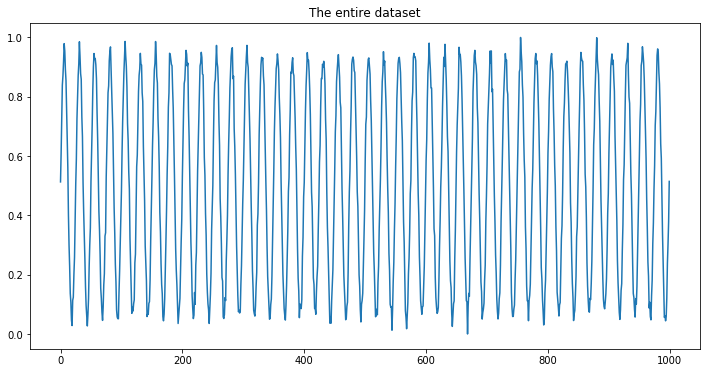

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(y_true)
plt.title("The entire dataset")

In [9]:
train_valid_split = 0.8
train_length = int(train_valid_split * len(y_true))
data_length = len(y_true)
valid_length = data_length-train_length
input_seq_length = 80
output_seq_length = 80
features_length = 1

In [10]:
def sample_sequences(v, start_ix, end_ix, seq_length, num_samples, random=False):        
    seq_start_indices = np.random.choice(np.arange(start_ix, end_ix-seq_length), size=num_samples, replace=True)    
    return v[np.array([np.arange(i, i+seq_length) for i in seq_start_indices])]

In [11]:
split_idx = int(len(y_true)*train_valid_split)
X_all = np.concatenate([sample_sequences(y_true, 0, split_idx, input_seq_length+output_seq_length, train_length),
                        sample_sequences(y_true, split_idx, len(y_true), input_seq_length+output_seq_length, valid_length)], axis=0)

In [12]:
train_indices = np.arange(train_length)
valid_indices = np.arange(train_length, data_length)
#np.random.shuffle(train_indices)

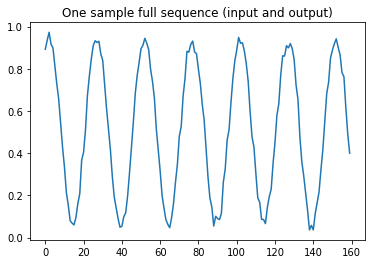

In [13]:
#should look like a sinusoid
plt.plot(np.concatenate((X_all[1, :input_seq_length, 0], X_all[1, input_seq_length:, 0])))
plt.title("One sample full sequence (input and output)")

In [14]:
X_train = X_all[train_indices, :input_seq_length, :]
y_train = X_all[train_indices, input_seq_length:, :]
X_valid = X_all[valid_indices, :input_seq_length, :]
y_valid = X_all[valid_indices, input_seq_length:, :]

In [15]:
# Temporal weights

t = np.arange(output_seq_length)
w = -(1+np.log10(1+t))
w = 1+w-w.min()
w = w/np.sum(w)
sample_weights = np.repeat(np.reshape(w, [1, output_seq_length]), train_length, axis=0)

In [163]:
np.random.seed(0)
tf.set_random_seed(0)

from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Lambda

lstm_units = 32

# expected input data shape: (batch_size, input_seq_length, features_length)
input_layer = Input(shape=(input_seq_length, features_length))

#layer = Lambda(lambda x: tf.pad(x[:, 1:] - x[:, :-1], [[0,0], [0,1], [0,0]]))(input_layer)
# layer = Lambda(lambda x: tf.concat([x, tf.pad(x[:, 1:] - x[:, :-1], [[0,0], [0,1], [0,0]])], axis=-1))(input_layer)
layer = input_layer

# encoder, we don't need the output
_, enc_hidden, enc_cell = LSTM(
    lstm_units, activation='tanh', return_sequences=False, return_state=True,
)(layer)

# decoder, is fed with zeros.
decoder_input = Input(tensor=K.zeros_like(input_layer))

output_layer = LSTM(
    lstm_units, activation='tanh', return_sequences=True
)(decoder_input, initial_state=[enc_hidden, enc_cell])

output_layer = TimeDistributed(Dense(1, activation='tanh'))(output_layer)
model = Model(inputs=[input_layer, decoder_input], outputs=output_layer)
model.compile(loss='mean_squared_error',
              optimizer='adagrad',
              #sample_weight_mode="temporal",
              metrics=['mean_absolute_error'])
model.summary()
hist = model.fit(X_train, y_train, 
                  #sample_weight=sample_weights,
                  batch_size=16, epochs=6,
                  validation_data=(X_valid, y_valid))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_82 (InputLayer)           (None, 80, 1)        0                                            
__________________________________________________________________________________________________
input_83 (InputLayer)           (None, 80, 1)        0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  [(None, 32), (None,  4352        input_82[0][0]                   
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 80, 32)       4352        input_83[0][0]                   
                                                                 lstm_37[0][1]                    
          

### The learning curve

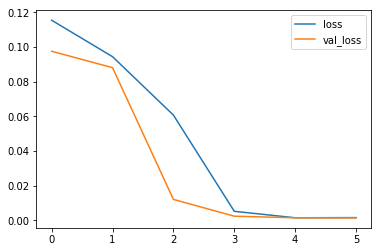

In [164]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

In [165]:
num_graphs = 16
g_per_rows = 4
g_per_cols = 4
n_rows = num_graphs // g_per_rows
n_cols = num_graphs // g_per_cols

### Visualize some samples from the training set

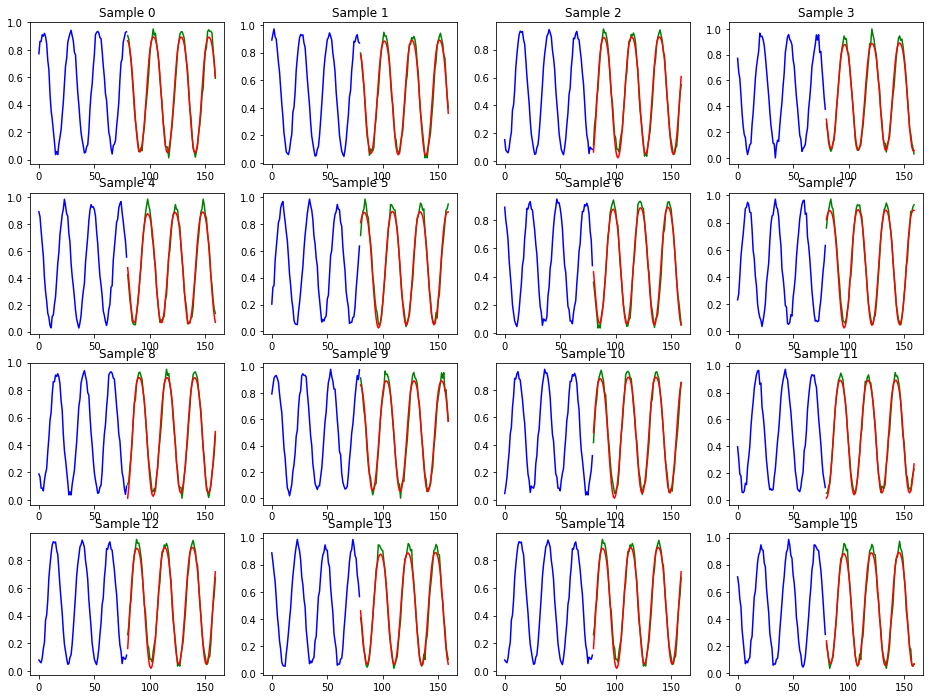

In [166]:
y_pred_train = model.predict(X_train)
plt.figure(figsize=(16, 12))
for i in np.arange(num_graphs):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title("Sample %d" % i)
    plt.plot(np.arange(input_seq_length), X_train[i, :, 0], label="input", color='b')
    plt.plot(np.arange(input_seq_length, input_seq_length+output_seq_length), y_train[i, :, 0], label="true", color='g')
    plt.plot(np.arange(input_seq_length, input_seq_length+output_seq_length), y_pred_train[i, :, 0], label="pred", color='r')

### Visualize some samples from the validation set

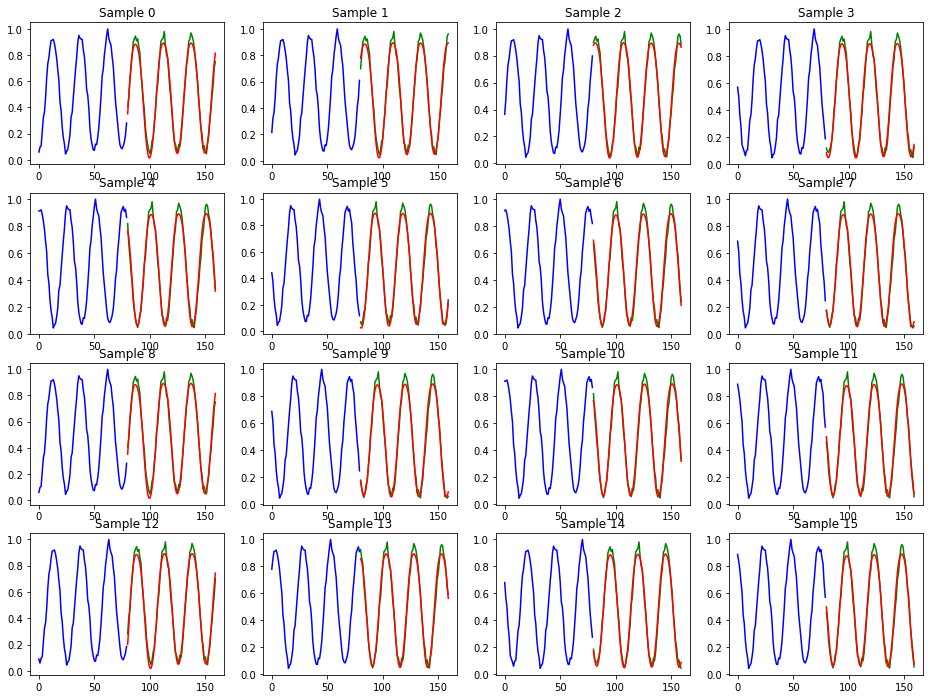

In [167]:
y_pred_valid = model.predict(X_valid)

plt.figure(figsize=(16, 12))
for i in np.arange(num_graphs):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title("Sample %d" % i)
    plt.plot(np.arange(input_seq_length), X_valid[i, :, 0], label="input", color='b')
    plt.plot(np.arange(input_seq_length, input_seq_length+output_seq_length), y_valid[i, :, 0], label="true", color='g')
    plt.plot(np.arange(input_seq_length, input_seq_length+output_seq_length), y_pred_valid[i, :, 0], label="pred", color='r')

### The errors

In [168]:
err = (y_pred_valid - y_valid).flatten()

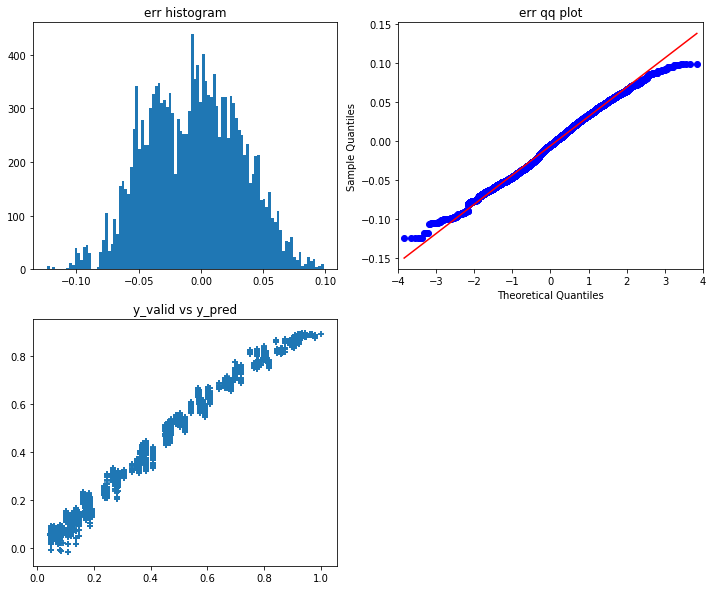

In [169]:
plt.figure(figsize=(12, 10))
layout = (2, 2)
plt.subplot2grid(layout, (0, 0))
_ = plt.hist(err, bins=100)
plt.title('err histogram')
qq_ax = plt.subplot2grid(layout, (0, 1))
_ = sm.qqplot(err, line='s', ax=qq_ax)
plt.title('err qq plot')
plt.subplot2grid(layout, (1, 0))
plt.title("y_valid vs y_pred")
_ = plt.scatter(y_valid, y_pred_valid, marker='+')

### Forecast multiple steps into the future

In [170]:
def forecast(start, n_sequences):
    current_seq = np.expand_dims(start, axis=0)
    predictions = []
    for i in range(n_sequences):
        current_seq = model.predict(current_seq)
        predictions.append(current_seq)
    return np.squeeze(np.concatenate(predictions, axis=1), axis=0)

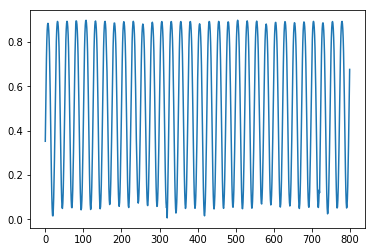

In [171]:
y_forecasted = forecast(X_valid[0], 10)
plt.plot(y_forecasted)